# Task 2b — Traffic Sign Shape Classification by Matthias Ellul

**Framework 2:** TensorFlow (Keras) image classification (transfer learning).

**Goal:** Given a cropped traffic-sign region, classify its **shape** (e.g., Circle / Triangle / Square / etc.) using the annotations in `COCO_sign_shape.json`.

This notebook:
1. Loads `COCO_sign_shape.json`
2. Crops sign regions from `Outputs/images/` using COCO bounding boxes
3. Builds a Keras dataset
4. Trains a transfer-learning classifier (MobileNetV2)
5. Evaluates quantitatively + qualitatively

> Note: To run the notebook, dataset paths needs to be changed since the repo structure had to be modified to align with submission requirements.

In [ ]:
# Setup: paths + imports
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd

# TensorFlow
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt

# Utils
from PIL import Image

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Expected inputs live in ./Outputs next to this notebook
ROOT = Path('.')
OUTPUTS = ROOT / 'Outputs'
IMAGES_DIR = OUTPUTS / 'images'
COCO_SHAPE_JSON = OUTPUTS / 'COCO_sign_shape.json'

assert IMAGES_DIR.exists(), f"Missing images directory: {IMAGES_DIR.resolve()}"
assert COCO_SHAPE_JSON.exists(), f"Missing COCO JSON: {COCO_SHAPE_JSON.resolve()}"

print('IMAGES_DIR:', IMAGES_DIR.resolve())
print('COCO_SHAPE_JSON:', COCO_SHAPE_JSON.resolve())
print('TensorFlow:', tf.__version__)


IMAGES_DIR: C:\Users\matth\OneDrive\Documents\UM\Advanced Computer Vision for AI\Group Project\Outputs\images
COCO_SHAPE_JSON: C:\Users\matth\OneDrive\Documents\UM\Advanced Computer Vision for AI\Group Project\Outputs\COCO_sign_shape.json
TensorFlow: 2.20.0


In [3]:
# --- Load COCO (shape-filtered) ---
with open(COCO_SHAPE_JSON, 'r', encoding='utf-8') as f:
    coco = json.load(f)

img_by_id = {im['id']: im for im in coco.get('images', [])}
anns = coco.get('annotations', [])

print('Images:', len(img_by_id))
print('Annotations:', len(anns))

# Robust attribute picker (your dataset uses keys like 'attr_shape', 'sign_shape', etc.)
def pick_first_attr(attr_dict, *keys, default=None):
    for k in keys:
        if k in attr_dict:
            v = attr_dict[k]
            if isinstance(v, list) and len(v) > 0:
                return v[0]
            if isinstance(v, str) and v.strip():
                return v
    return default

# Inspect a few attribute dicts to confirm key names
sample_attrs = [a.get('attributes', {}) for a in random.sample(anns, k=min(5, len(anns)))]
for i, ad in enumerate(sample_attrs, 1):
    print(f"Attr sample {i}:", ad)


Images: 620
Annotations: 654
Attr sample 1: {'view_angle': ['Side'], 'mounting': ['Pole-mounted'], 'condition': ['Good'], 'sign_shape': ['Circular']}
Attr sample 2: {'view_angle': ['Back'], 'mounting': ['Pole-mounted'], 'condition': ['Good'], 'sign_shape': ['Triangular']}
Attr sample 3: {'attr_angle': ['Front'], 'attr_mounting': ['Pole-mounted'], 'attr_condition': ['Good'], 'attr_shape': ['Square'], 'view_angle': [], 'mounting': [], 'condition': [], 'sign_shape': []}
Attr sample 4: {'attr_angle': ['Front'], 'attr_mounting': ['Pole-mounted'], 'attr_condition': ['Good'], 'attr_shape': ['Octagonal'], 'view_angle': [], 'mounting': [], 'condition': [], 'sign_shape': []}
Attr sample 5: {'attr_angle': ['Side'], 'attr_mounting': ['Wall-mounted'], 'attr_condition': ['Good'], 'attr_shape': ['Square'], 'view_angle': [], 'mounting': [], 'condition': [], 'sign_shape': []}


In [ ]:
# Build a crop dataset on disk (one folder per shape class)
# This makes training simple via tf.keras.utils.image_dataset_from_directory.

DATASET_DIR = OUTPUTS / 'tf_sign_shape_dataset'
CROPS_DIR = DATASET_DIR / 'crops'

# Crop settings
MIN_BOX_PX = 16          # skip extremely tiny boxes
PADDING = 0.05           # expand bbox a bit (5%)
MAX_SAMPLES_PER_CLASS = None  # set e.g. 500 if you want to balance quickly

# Map annotation -> shape label
# Try common keys; fall back to None.
def get_shape_label(ann):
    ad = ann.get('attributes', {}) or {}
    label = pick_first_attr(ad,
                            'attr_shape', 'sign_shape', 'attr_sign_shape', 'shape',
                            'attr_signshape', 'sign_shape_type')
    if label is None:
        return None
    # Normalize label strings
    label = str(label).strip()
    label = label.replace('-', ' ').replace('_', ' ')
    label = ' '.join(label.split())
    return label

# Clean output folder
import shutil
if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)
CROPS_DIR.mkdir(parents=True, exist_ok=True)

# Count per class
counts = {}
written = 0
skipped = 0

for ann in anns:
    image_id = ann.get('image_id')
    rec = img_by_id.get(image_id)
    if rec is None:
        skipped += 1
        continue

    shape = get_shape_label(ann)
    if shape is None:
        skipped += 1
        continue

    # Optional per-class cap
    if MAX_SAMPLES_PER_CLASS is not None and counts.get(shape, 0) >= MAX_SAMPLES_PER_CLASS:
        continue

    file_name = rec.get('file_name')
    img_path = IMAGES_DIR / file_name
    if not img_path.exists():
        skipped += 1
        continue

    # COCO bbox: [x, y, w, h]
    x, y, w, h = ann.get('bbox', [0,0,0,0])
    if w < MIN_BOX_PX or h < MIN_BOX_PX:
        skipped += 1
        continue

    # Load image (PIL)
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        skipped += 1
        continue

    W, H = img.size

    # Apply padding
    pad_x = int(w * PADDING)
    pad_y = int(h * PADDING)

    x1 = max(0, int(x) - pad_x)
    y1 = max(0, int(y) - pad_y)
    x2 = min(W, int(x + w) + pad_x)
    y2 = min(H, int(y + h) + pad_y)

    if x2 <= x1 or y2 <= y1:
        skipped += 1
        continue

    crop = img.crop((x1, y1, x2, y2))

    # Save crop
    class_dir = CROPS_DIR / shape
    class_dir.mkdir(parents=True, exist_ok=True)

    # Unique name: <imgstem>_ann<id>.jpg
    ann_id = ann.get('id', written)
    out_name = f"{Path(file_name).stem}_ann{ann_id}.jpg"
    out_path = class_dir / out_name

    try:
        crop.save(out_path, quality=95)
        counts[shape] = counts.get(shape, 0) + 1
        written += 1
    except Exception:
        skipped += 1

print('Wrote crops:', written)
print('Skipped:', skipped)

# Show class distribution
dist = pd.DataFrame(sorted(counts.items(), key=lambda x: x[1], reverse=True), columns=['shape', 'count'])
display(dist)


Wrote crops: 498
Skipped: 156


,shape,count
0,Circular,205
1,Octagonal,112
2,Square,98
3,Triangular,77
4,Damaged,6


In [ ]:
# Create tf.data datasets
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # on CPU, 16-32 is usually okay; reduce if RAM is limited

train_ds = tf.keras.utils.image_dataset_from_directory(
    CROPS_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    CROPS_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes:', class_names)
print('num_classes:', num_classes)

# Performance optimizations
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1024, seed=SEED).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


Found 498 files belonging to 5 classes.
Using 399 files for training.
Found 498 files belonging to 5 classes.
Using 99 files for validation.
Classes: ['Circular', 'Damaged', 'Octagonal', 'Square', 'Triangular']
num_classes: 5


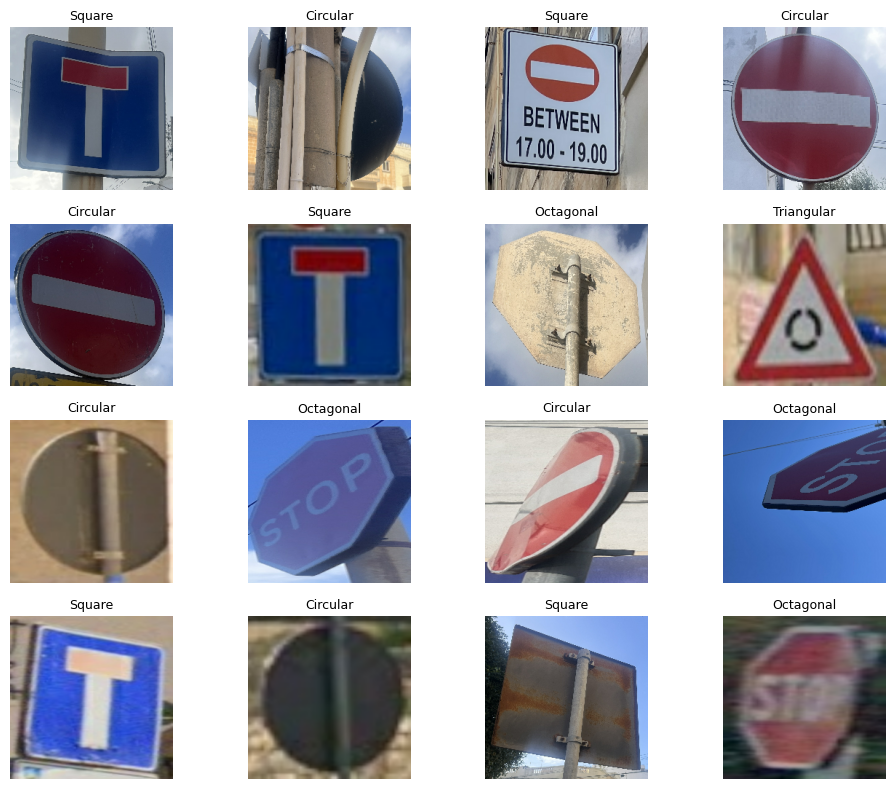

In [ ]:
# Quick visual sanity check of crops
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(min(16, images.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i])], fontsize=9)
        plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Model: MobileNetV2 transfer learning
# Data augmentation (lightweight)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name='augment')

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train (stage 1: train classifier head)
EPOCHS = 20

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3258 - loss: 1.6028 - val_accuracy: 0.4848 - val_loss: 1.1980
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 976ms/step - accuracy: 0.6516 - loss: 0.9841 - val_accuracy: 0.5657 - val_loss: 0.8829
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 954ms/step - accuracy: 0.7243 - loss: 0.7556 - val_accuracy: 0.6566 - val_loss: 0.7918
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 968ms/step - accuracy: 0.7644 - loss: 0.6187 - val_accuracy: 0.7071 - val_loss: 0.6900
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8095 - loss: 0.5392 - val_accuracy: 0.7374 - val_loss: 0.6559
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 965ms/step - accuracy: 0.8195 - loss: 0.4840 - val_accuracy: 0.7576 - val_loss: 0.6032
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 982ms/step - accuracy: 0.8722 - loss: 0.3972 - val_accuracy: 0.7778 - val_loss: 0.6030
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 962ms/step - accuracy: 0.8496 - loss: 0.4114 - val_accuracy: 

In [ ]:
# Fine-tune last layers (stage 2)
FINE_TUNE = True

if FINE_TUNE:
    base.trainable = True
    # Freeze most layers; unfreeze last ~30
    for layer in base.layers[:-30]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history_ft = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=8,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]
    )


Epoch 1/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8772 - loss: 0.3590 - val_accuracy: 0.8485 - val_loss: 0.4069
Epoch 2/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9424 - loss: 0.2022 - val_accuracy: 0.8687 - val_loss: 0.4149
Epoch 3/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9624 - loss: 0.1321 - val_accuracy: 0.8283 - val_loss: 0.4446
Epoch 4/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9699 - loss: 0.1241 - val_accuracy: 0.8687 - val_loss: 0.4095
Epoch 5/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9749 - loss: 0.0923 - val_accuracy: 0.8485 - val_loss: 0.4743


**************************
Validation accuracy: 0.869
**************************


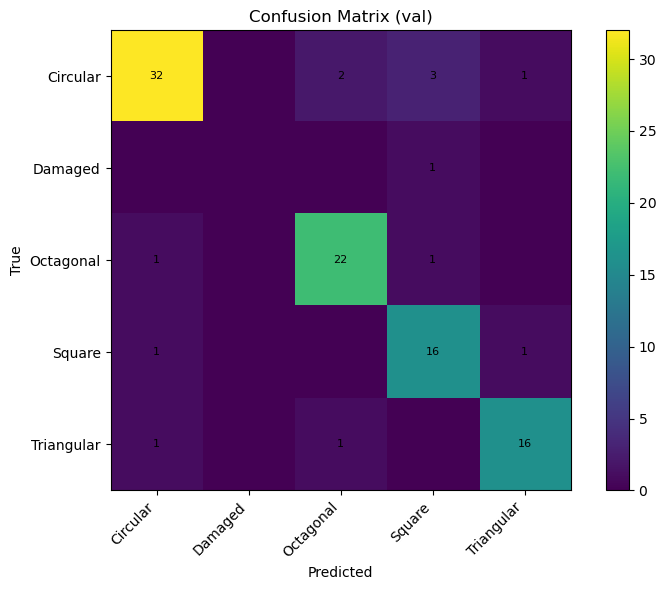

Classification report:
              precision    recall  f1-score   support

    Circular      0.914     0.842     0.877        38
     Damaged      0.000     0.000     0.000         1
   Octagonal      0.880     0.917     0.898        24
      Square      0.762     0.889     0.821        18
  Triangular      0.889     0.889     0.889        18

    accuracy                          0.869        99
   macro avg      0.689     0.707     0.697        99
weighted avg      0.864     0.869     0.865        99



In [ ]:
# Quantitative evaluation: accuracy + confusion matrix + per-class report
from sklearn.metrics import confusion_matrix, classification_report

# Collect predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = (y_true == y_pred).mean()
print("*" * 26)
print(f"Validation accuracy: {acc:.3f}")
print("*" * 26)

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title('Confusion Matrix (val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.yticks(range(num_classes), class_names)
plt.colorbar()

# Add numbers
for i in range(num_classes):
    for j in range(num_classes):
        v = cm[i, j]
        if v:
            plt.text(j, i, str(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print('Classification report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))


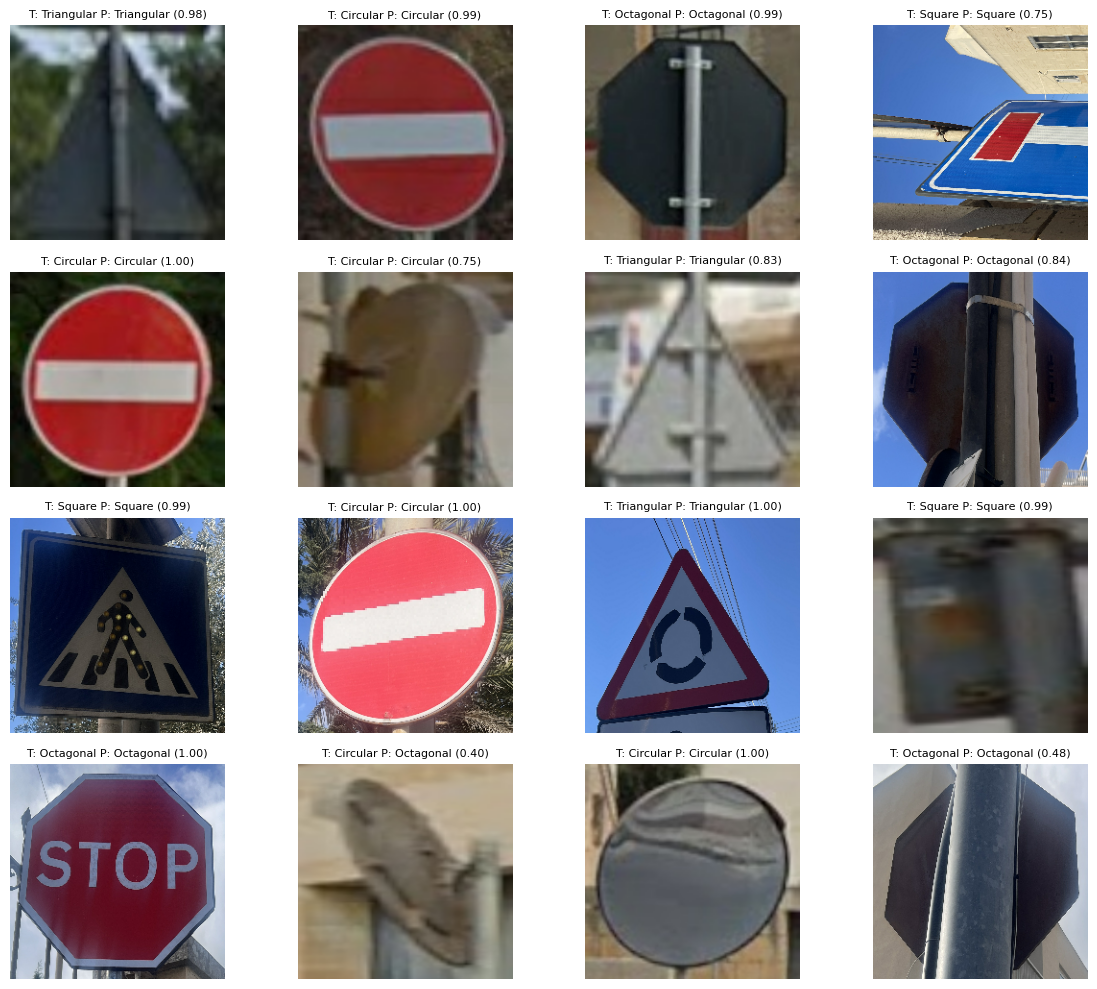

In [ ]:
# Qualitative: show some validation crops with predictions
# Shows readability of shape classification.

# Take one batch from val
images, labels = next(iter(val_ds))
probs = model.predict(images, verbose=0)
preds = np.argmax(probs, axis=1)

plt.figure(figsize=(12, 10))
for i in range(min(16, images.shape[0])):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    true_name = class_names[int(labels[i])]
    pred_name = class_names[int(preds[i])]
    conf = float(np.max(probs[i]))
    title = f"T: {true_name} P: {pred_name} ({conf:.2f})"
    plt.title(title, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Save the trained classifier
MODEL_OUT = OUTPUTS / 'tf_sign_shape_classifier.keras'
model.save(MODEL_OUT)
print('Saved model to:', MODEL_OUT.resolve())

Saved model to: C:\Users\matth\OneDrive\Documents\UM\Advanced Computer Vision for AI\Group Project\Outputs\tf_sign_shape_classifier.keras
